This notebook is based on the file [Intro to Neural Nets programming exercise](https://colab.research.google.com/notebooks/mlcc/intro_to_neural_nets.ipynb?utm_source=mlcc&utm_campaign=colab-external&utm_medium=referral&utm_content=introneuralnets-colab&hl=en), which is part of Google's [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/).

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Intro to Neural Networks

**Learning Objectives:**
  * Define a neural network (NN) and its hidden layers 
  * Train a neural network to learn nonlinearities in a dataset and achieve better performance than a linear regression model

In the previous exercises, we used synthetic features to help our model incorporate nonlinearities.

One important set of nonlinearities was around latitude and longitude, but there may be others.

We'll also switch back, for now, to a standard regression task, rather than the logistic regression task from the previous exercise. That is, we'll be predicting `median_house_value` directly.

## Setup

First, let's load and prepare the data.

In [1]:
using Plots
using Distributions
gr()
using DataFrames
using TensorFlow
import CSV
import StatsBase
using PyCall

sess=Session(Graph())
california_housing_dataframe = CSV.read("california_housing_train.csv", delim=",");
california_housing_dataframe = california_housing_dataframe[shuffle(1:size(california_housing_dataframe, 1)),:];

In [2]:
function preprocess_features(california_housing_dataframe)
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    [:latitude,
     :longitude,
     :housing_median_age,
     :total_rooms,
     :total_bedrooms,
     :population,
     :households,
     :median_income]]
  processed_features = selected_features
  # Create a synthetic feature.
  processed_features[:rooms_per_person] = (
    california_housing_dataframe[:total_rooms] ./
    california_housing_dataframe[:population])
  return processed_features
end
    
function preprocess_targets(california_housing_dataframe)
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets[:median_house_value] = (
    california_housing_dataframe[:median_house_value] ./ 1000.0)
  return output_targets
end

preprocess_targets (generic function with 1 method)

2018-08-28 19:53:28.011439: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.2 AVX AVX2 FMA


In [3]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(head(california_housing_dataframe,12000))
training_targets = preprocess_targets(head(california_housing_dataframe,12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(tail(california_housing_dataframe,5000))
validation_targets = preprocess_targets(tail(california_housing_dataframe,5000))

# Double-check that we've done the right thing.
println("Training examples summary:")
describe(training_examples)
println("Validation examples summary:")
describe(validation_examples)

println("Training targets summary:")
describe(training_targets)
println("Validation targets summary:")
describe(validation_targets)

Training examples summary:


,variable,mean,min,median,max,nunique,nmissing,eltype
1,median_house_value,204.971,14.999,179.2,500.001,,,Float64


Validation examples summary:
Training targets summary:
Validation targets summary:


## Building a Neural Network

Use **`hidden_units`** to define the structure of the NN.  The `hidden_units` argument provides a list of ints, where each int corresponds to a hidden layer and indicates the number of nodes in it.  For example, consider the following assignment:

`hidden_units=[3,10]`

The preceding assignment specifies a neural net with two hidden layers:

* The first hidden layer contains 3 nodes.
* The second hidden layer contains 10 nodes.

If we wanted to add more layers, we'd add more ints to the list. For example, `hidden_units=[10,20,30,40]` would create four layers with ten, twenty, thirty, and forty units, respectively.

By default, all hidden layers will use ReLu activation and will be fully connected.

In [4]:
function construct_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: DataFrame of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  out=convert(Array, input_features[:,:])
  return convert.(Float64,out)
    
end

construct_columns (generic function with 1 method)

In [5]:
function create_batches(features, targets, steps, batch_size=5, num_epochs=0)
  """Create batches.

  Args:
    features: Input features.
    targets: Target column.
    steps: Number of steps.
    batch_size: Batch size.
    num_epochs: Number of epochs, 0 will let TF automatically calculate the correct number
  Returns:
    An extended set of feature and target columns from which batches can be extracted.
  """  
    
    if(num_epochs==0)
        num_epochs=ceil(batch_size*steps/size(features,1))
    end
    
    names_features=names(features);
    names_targets=names(targets);
    
    features_batches=copy(features)
    target_batches=copy(targets)

    for i=1:num_epochs
        
        select=shuffle(1:size(features,1))
     
        if i==1
            features_batches=(features[select,:])
            target_batches=(targets[select,:])
        else
            
            append!(features_batches, features[select,:])
            append!(target_batches, targets[select,:])
        end
    end
    return features_batches, target_batches 
end

create_batches (generic function with 3 methods)

In [6]:
function next_batch(features_batches, targets_batches, batch_size, iter)
  """Next batch.

  Args:
    features_batches: Features batches from create_batches.
    targets_batches: Target batches from create_batches.
    batch_size: Batch size.
    iter: Number of the current iteration
  Returns:
    An extended set of feature and target columns from which batches can be extracted.
  """ 
    select=mod((iter-1)*batch_size+1, size(features_batches,1)):mod(iter*batch_size, size(features_batches,1));

    ds=features_batches[select,:];
    target=targets_batches[select,:];
    
    return ds, target
end

next_batch (generic function with 1 method)

In [10]:
function my_input_fn(features_batches, targets_batches, iter, batch_size=5, shuffle_flag=1):
    """Prepares a batch of features and labels for model training.
  
    Args:
      features_batches: Features batches from create_batches.
      targets_batches: Target batches from create_batches.
      iter: Number of the current iteration
      batch_size: Batch size.
      shuffle_flag: Determines wether data is shuffled before being returned
    Returns:
      Tuple of (features, labels) for next data batch
    """                                          
 
    # Construct a dataset, and configure batching/repeating.
    ds, target = next_batch(features_batches, targets_batches, batch_size, iter)
    
    # Shuffle the data, if specified.
    if shuffle_flag==1
      select=shuffle(1:size(ds, 1));
        ds = ds[select,:]
        target = target[select, :]
    end
    
    # Return the next batch of data.
    return ds, target
end

my_input_fn (generic function with 3 methods)

In [8]:
function train_nn_regression_model(learning_rate,
                     steps, 
                     batch_size, 
                     hidden_units,
                     keep_probability,
                     training_examples, 
                     training_targets, 
                     validation_examples, 
                     validation_targets)
  """Trains a neural network model of one feature.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A vector describing the layout of the neural network
    keep_probability: A `float`, the probability of keeping a node active during one training step.
  """
  
  periods = 10
  steps_per_period = steps / periods

  # Create feature columns.
  feature_columns = placeholder(Float32, shape=[-1, size(construct_columns(training_examples),2)])
  target_columns = placeholder(Float32, shape=[-1, size(construct_columns(training_targets),2)])
  
  # Network parameters
  push!(hidden_units,size(training_targets,2)) #create an output node that fits to the size of the targets
  activation_functions = Vector{Function}(size(hidden_units,1))
  activation_functions[1:end-1]=z->nn.dropout(nn.relu(z), keep_probability)
  activation_functions[end] = identity #Last function should be idenity as we need the logits  
    
  # create network - professional template
  Zs = [feature_columns]
  for (ii,(hlsize, actfun)) in enumerate(zip(hidden_units, activation_functions))
        Wii = get_variable("W_$ii"*randstring(4), [get_shape(Zs[end], 2), hlsize], Float32)
        bii = get_variable("b_$ii"*randstring(4), [hlsize], Float32)
        Zii = actfun(Zs[end]*Wii + bii)
        push!(Zs, Zii)
  end
  
  y=Zs[end]
  loss=reduce_sum((target_columns - y).^2)
 
  features_batches, targets_batches = create_batches(training_examples, training_targets, steps, batch_size)
   
  # Advanced gradient decent with gradient clipping
  my_optimizer=(train.AdamOptimizer(learning_rate))
  gvs = train.compute_gradients(my_optimizer, loss)
  capped_gvs = [(clip_by_norm(grad, 5.), var) for (grad, var) in gvs]
  my_optimizer = train.apply_gradients(my_optimizer,capped_gvs)
    
  run(sess, global_variables_initializer())
    
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  println("Training model...")
  println("RMSE (on training data):")
  training_rmse = []
  validation_rmse=[]
  
  for period in 1:periods
    # Train the model, starting from the prior state.
   for i=1:steps_per_period
    features, labels = my_input_fn(features_batches, targets_batches, convert(Int,(period-1)*steps_per_period+i), batch_size)
    run(sess, my_optimizer, Dict(feature_columns=>construct_columns(features), target_columns=>construct_columns(labels)))
   end
    # Take a break and compute predictions.
    training_predictions = run(sess, y, Dict(feature_columns=> construct_columns(training_examples)));    
    validation_predictions = run(sess, y, Dict(feature_columns=> construct_columns(validation_examples)));  
                                   
    # Compute loss.
     training_mean_squared_error = mean((training_predictions- construct_columns(training_targets)).^2)
     training_root_mean_squared_error = sqrt(training_mean_squared_error)
     validation_mean_squared_error = mean((validation_predictions- construct_columns(validation_targets)).^2)
     validation_root_mean_squared_error = sqrt(validation_mean_squared_error)
    # Occasionally print the current loss.
    println("  period ", period, ": ", training_root_mean_squared_error)
    # Add the loss metrics from this period to our list.
    push!(training_rmse, training_root_mean_squared_error)
    push!(validation_rmse, validation_root_mean_squared_error)
 end
    
  println("Model training finished.")

  # Output a graph of loss metrics over periods.
  p1=plot(training_rmse, label="training", title="Root Mean Squared Error vs. Periods", ylabel="RMSE", xlabel="Periods")
  p1=plot!(validation_rmse, label="validation")
    
  #
  println("Final RMSE (on training data): ", training_rmse[end])
  println("Final RMSE (on validation data): ", validation_rmse[end])
    
  return y, feature_columns, p1 
end

train_nn_regression_model (generic function with 1 method)

## Task 1: Train a NN Model

**Adjust hyperparameters, aiming to drop RMSE below 110.**

Run the following block to train a NN model.  

Recall that in the linear regression exercise with many features, an RMSE of 110 or so was pretty good.  We'll aim to beat that.

Your task here is to modify various learning settings to improve accuracy on validation data.

Overfitting is a real potential hazard for NNs.  You can look at the gap between loss on training data and loss on validation data to help judge if your model is starting to overfit. If the gap starts to grow, that is usually a sure sign of overfitting.

Because of the number of different possible settings, it's strongly recommended that you take notes on each trial to help guide your development process.

Also, when you get a good setting, try running it multiple times and see how repeatable your result is. NN weights are typically initialized to small random values, so you should see differences from run to run.


In [11]:
 output_function, output_columns, p1 = train_nn_regression_model(
    # TWEAK THESE VALUES TO SEE HOW MUCH YOU CAN IMPROVE THE RMSE
    0.001, #learning rate
    2000, #steps
    100, #batch_size
    [10, 10], #hidden_units
    1.0, # keep probability
    training_examples,
    training_targets,
    validation_examples,
    validation_targets)

Training model...
RMSE (on training data):
  period 1: 159.4496119647554
  period 2: 137.93344485653017
  period 3: 108.14011894663264
  period 4: 103.01777894846809
  period 5: 100.97255058089709
  period 6: 99.20262746001677
  period 7: 97.82305274853516
  period 8: 96.84022619976578
  period 9: 95.86283686804012
  period 10: 94.40079308853126
Model training finished.


(<Tensor Identity_2:1 shape=(?, 1) dtype=Float32>, <Tensor placeholder_3:1 shape=(?, 9) dtype=Float32>, Plot{Plots.GRBackend() n=2})

Final RMSE (on training data): 94.40079308853126
Final RMSE (on validation data): 92.44566161191445


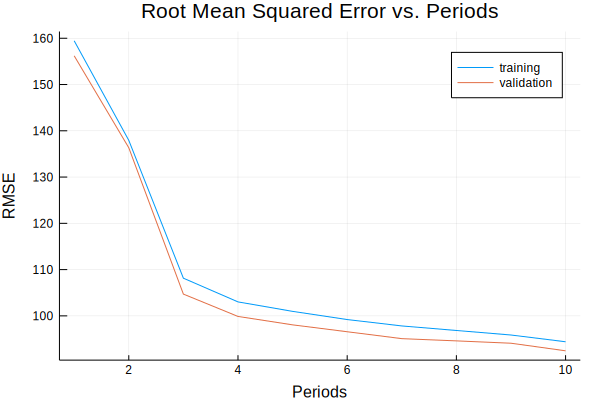

In [12]:
plot(p1)

## Task 2: Evaluate on Test Data

**Confirm that your validation performance results hold up on test data.**

Once you have a model you're happy with, evaluate it on test data to compare that to validation performance.

Reminder, the test data set is located [here](https://storage.googleapis.com/mledu-datasets/california_housing_test.csv).

Similar to what the code at the top does, we just need to load the appropriate data file, preprocess it and call predict and mean_squared_error.

Note that we don't have to randomize the test data, since we will use all records.

In [13]:
california_housing_test_data  = CSV.read("california_housing_test.csv", delim=",");
test_examples = preprocess_features(california_housing_test_data)
test_targets = preprocess_targets(california_housing_test_data)

test_predictions  = run(sess, output_function, Dict(output_columns=> construct_columns(test_examples))); 
test_mean_squared_error = mean((test_predictions- construct_columns(test_targets)).^2)
test_root_mean_squared_error = sqrt(test_mean_squared_error)

print("Final RMSE (on test data): ", test_root_mean_squared_error)

Final RMSE (on test data): 93.26327423962617

In [ ]:
#EOF